In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pprint
import random
import os
import glob
from astropy.visualization import ZScaleInterval
import cv2
import tqdm

In [2]:
path = './data/'
files_name = glob.glob(os.path.join(path, "*.fits"))
files_name

['./data/hst_14610_30_acs_wfc_f814w_jdb630_drc.fits']

In [3]:
hdu_list = fits.open(files_name[0])
hdu_list.info()

Filename: ./data/hst_14610_30_acs_wfc_f814w_jdb630_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     897   ()      
  1  SCI           1 ImageHDU        83   (5931, 5926)   float32   
  2  WHT           1 ImageHDU        44   (5931, 5926)   float32   
  3  CTX           1 ImageHDU        37   (5931, 5926)   int32   
  4  HDRTAB        1 BinTableHDU    638   8R x 314C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 3A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, D, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 4A, L, D, D, D, 3A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 6A, 9A, 8A, D, D, L, 9A, 44A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 6A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, 

In [4]:
image_data = hdu_list['SCI'].data
image_data.shape

(5926, 5931)

In [5]:
np.save('data/test_val', image_data)

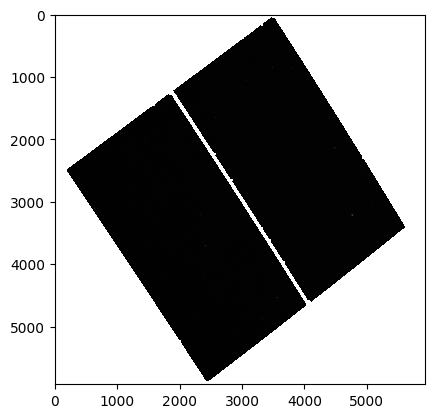

In [6]:
x = np.load('data/test_val.npy')
plt.imshow(x, cmap='gray')

In [7]:
def plot_sub_region(path_item_i):
    # plot all cropped image in cropped_list by row and column come from square root of length of cropped_list then plot scatter of coordinate of the object
    plt.rcParams['figure.figsize'] = [7, 7]
    # plot all cropped image in list by row and column come from square root of length of list
    row = int(np.sqrt(len(path_item_i)))
    column = int(np.sqrt(len(path_item_i)))
    for i in range(len(path_item_i)):
        plt.subplot(row, column, i+1)
        plt.imshow(np.load(path_item_i[i]), cmap="gray")
    plt.show()

# function

In [8]:
def crop_subregions(image, subregion_size, output_folder):
    height, width = image.shape
    subregion_height, subregion_width = subregion_size

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    subregion_filenames = []
    counter = 0
    for y in range(0, height, subregion_height):
        for x in range(0, width, subregion_width):
            subregion = image[y:y+subregion_height, x:x+subregion_width]
            filename = os.path.join(output_folder, f'subregion_{y}_{x}.npy')
            filename_for_plot = os.path.join(output_folder + '/plotter', f'subregion_{counter}.png')
            np.save(filename, subregion)
            np.save(filename_for_plot, subregion)
            counter += 1
            subregion_filenames.append(filename)

    return subregion_filenames

def combine_subregions(subregion_folder, image_size, cropped_size = 1024):
    image_height, image_width = image_size
    subregion_width = cropped_size
    subregion_height = cropped_size

    num_subregions_height = image_height // subregion_height
    num_subregions_width = image_width // subregion_width

    image = np.zeros((image_height, image_width), dtype=np.float32)

    for y in range(0, image_height, subregion_height):
        for x in range(0, image_width, subregion_width):
            filename = os.path.join(subregion_folder, f'subregion_{y}_{x}.npy')
            subregion = np.load(filename)
            image[y:y+subregion_height, x:x+subregion_width] = subregion

    return image

In [ ]:
""" Last modified crop & merge function """
# """ Cropping function """
# def crop_subregions(image, subregion_size, output_folder):
#     original_height, original_width = image.shape
#     subregion_height, subregion_width = subregion_size
#     print(f"original shape: {colorstr('bold', image.shape)}")

#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     for y in range(0, original_height, subregion_height):
#         for x in range(0, original_width, subregion_width):
#             # if subregion hight or width is not out of bound, then crop with normal case
#             if y + subregion_height <= original_height and x + subregion_width <= original_width:
#                 subregion = image[y:y+subregion_height, x:x+subregion_width]
#             elif y + subregion_height <= original_height and x + subregion_width > original_width:
#                 subregion = image[y:y+subregion_height, x::]
#             elif y + subregion_height > original_height and x + subregion_width <= original_width:
#                 subregion = image[y::, x:x+subregion_width]
#             elif y + subregion_height > original_height and x + subregion_width > original_width:
#                 subregion = image[y::, x::]
#             # otherwise, crop with only remaining part in the image
#             else:
#                 print('Warning: subregion is out of bound')
                
#             filename = os.path.join(output_folder, f'subregion_{y}_{x}.npy')
#             np.save(filename, subregion)
#             print('shape of subregion: ', subregion.shape)

# def combine_subregions(subregion_folder, detected_labels_folder, image_size, cropped_size):
#     image_height, image_width = image_size
#     subregion_width, subregion_height = cropped_size[0], cropped_size[1]

#     # load whole labels
#     labels_list = glob.glob(os.path.join(detected_labels_folder, '*'))
#     labels_list = [i.split('/')[-1].split('.')[0] for i in labels_list]

#     image = np.zeros((image_height, image_width), dtype=np.float32)
#     print(f"shape of merging image: {colorstr('bold', image.shape)}")

#     labels_for_merged_image = []
#     for y in range(0, image_height, subregion_height):
#         for x in range(0, image_width, subregion_width):
#             filename = os.path.join(subregion_folder, f'subregion_{y}_{x}.npy')
#             subregion = np.load(filename)
#             filename_x = filename.split('/')[-1].split('.')[0]
#             if filename_x in labels_list:
#                 # this below code to load labels then convert from subregion coordinate to original image coordinate
#                 # load labels which are same name with subregion
#                 with open(os.path.join(detected_labels_folder, f'{filename_x}.txt'), 'r') as f:
#                     labels = f.readlines()
#                 # the example of labels
#                 # class x_center y_center width height
#                 # 0 0.29541 0.258789 0.196289 0.195312 0.906503
#                 # 0 0.35498 0.889648 0.194336 0.195312 0.918074
#                 # here we need to convert yolo format to pixel coordinate (0-1 to pixel coordinate)
#                 # then convert subregion coordinate to original image coordinate (change the coordinate from subregion to original image)
#                 # final result is center x, center y, width, height in pixel unit
#                 # convert YOLO format to pixel coordinate (0-1 to pixel coordinate)
#                 labels = [label.split() for label in labels]
#                 for label in labels:
#                     class_index = int(label[0])
#                     x_center = float(label[1])
#                     y_center = float(label[2])
#                     width = float(label[3])
#                     height = float(label[4])

#                     # Convert from YOLO format to pixel coordinates
#                     x_center = x_center * subregion_width + x
#                     y_center = y_center * subregion_height + y
#                     width = width * subregion_width
#                     height = height * subregion_height

#                     # Convert from subregion coordinate to original image coordinate
#                     x_center = min(max(x_center, 0), image_width)
#                     y_center = min(max(y_center, 0), image_height)
#                     width = min(width, image_width - x_center)
#                     height = min(height, image_height - y_center)

#                     # Append the converted label to the list
#                     labels_for_merged_image.append([class_index, x_center, y_center, width, height])
                    
#             # if shape of subregion is greater than 2 dimensions, then convert to 2 dimensions
#             # by taking only last 2 dimensions
#             if len(subregion.shape) > 2:
#                 subregion = subregion[0, 0, :, :]

#             # if subregion hight or width is not out of bound, then fill
#             if y + subregion_height <= image_height and x + subregion_width <= image_width:
#                 image[y:y+subregion_height, x:x+subregion_width] = subregion
#             elif y + subregion_height <= image_height and x + subregion_width > image_width:
#                 image[y:y+subregion_height, x::] = subregion[:, 0:image_width-x]
#             elif y + subregion_height > image_height and x + subregion_width <= image_width:
#                 image[y::, x:x+subregion_width] = subregion[0:image_height-y, :]
#             elif y + subregion_height > image_height and x + subregion_width > image_width:
#                 image[y::, x::] = subregion[0:image_height-y, 0:image_width-x]
#             # otherwise, fill with only remaining part in the image
#             else:
#                 print('Warning: subregion is out of bound')

#     return image, labels_for_merged_image

In [9]:
x.shape

(5926, 5931)

In [10]:
import numpy as np

# Load the original image data
original_image = x

# Define the size of the sub-regions
subregion_size = (1024, 1024)

# Specify the output folder
output_folder = 'subregion_folder'

# Crop the sub-regions and save them into the folder
subregion_filenames = crop_subregions(original_image, subregion_size, output_folder)


# sub image

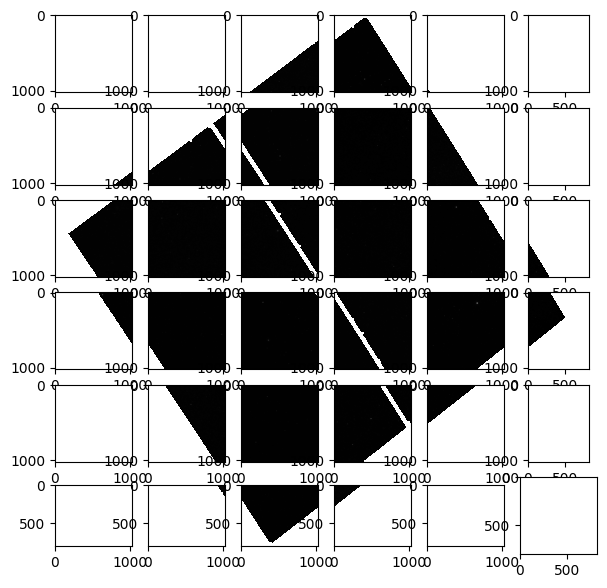

In [11]:
path_sub_region = glob.glob(os.path.join('./subregion_folder/plotter', "*.npy"))
# sort
path_sub_region.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
plot_sub_region(path_sub_region)

# big image

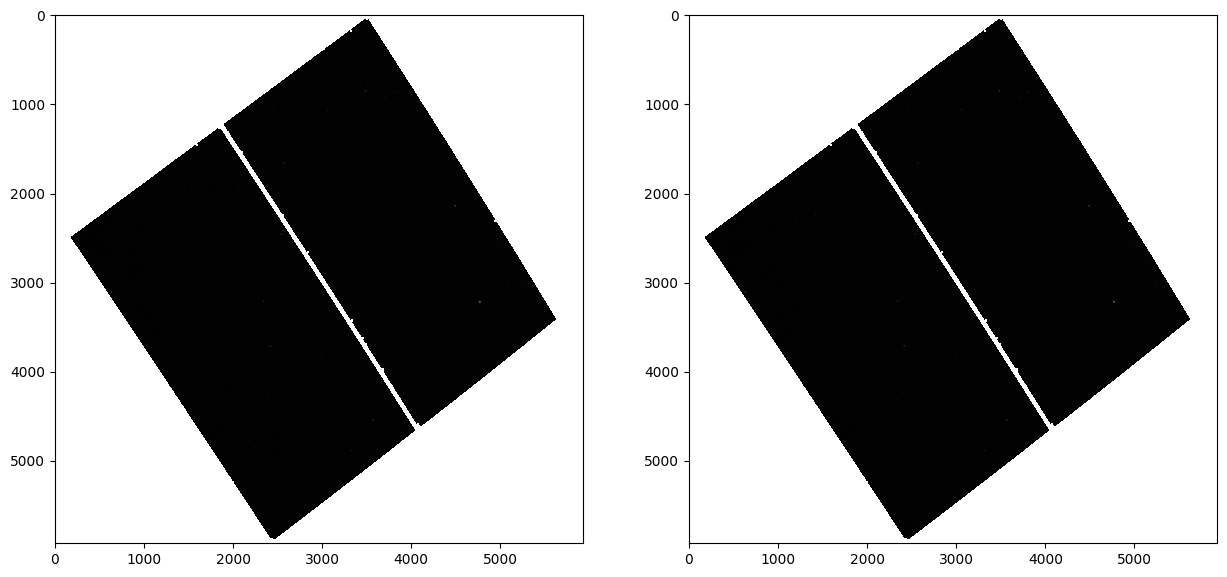

In [12]:
# Specify the subregion folder
subregion_folder = 'subregion_folder'

# Combine the sub-regions back to the original image
output_image = combine_subregions(subregion_folder, original_image.shape)


plt.rcParams['figure.figsize'] = [15, 15]
# plot x side by side with output_image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap="gray")
plt.show()